# Example EEG signals from New York Head model
Demonstration of EEG predictions from single synaptic input, using a complex head model 

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import LFPy
from matplotlib.gridspec import GridSpec
from lfpykit.eegmegcalc import NYHeadModel
from lfpykit import CellGeometry, CurrentDipoleMoment

In [2]:
# create LFPy.Cell object
cell = LFPy.Cell(morphology=os.path.join(LFPy.__path__[0], 'test',
                             'ball_and_sticks.hoc'), passive=True)

# create single synaptic stimuli
syn = LFPy.Synapse(cell, idx=0, syntype='ExpSyn', 
                   weight=0.01, tau=5, record_current=True)
syn.set_spike_times_w_netstim()

# simulate, record currents
cell.simulate(rec_imem=True)

# create CellGeometry object. This part is independent of LFPy
cell_geometry = CellGeometry(
    x=np.c_[cell.xstart, cell.xend],
    y=np.c_[cell.ystart, cell.yend],
    z=np.c_[cell.zstart, cell.zend],
    d=cell.diam)

# calculate current dipole moment
cdm = CurrentDipoleMoment(cell=cell_geometry)
p = cdm.get_transformation_matrix() @ cell.imem


 We first plot the cell response to the synaptic input

Text(0.5, 0, '$t$ (ms)')

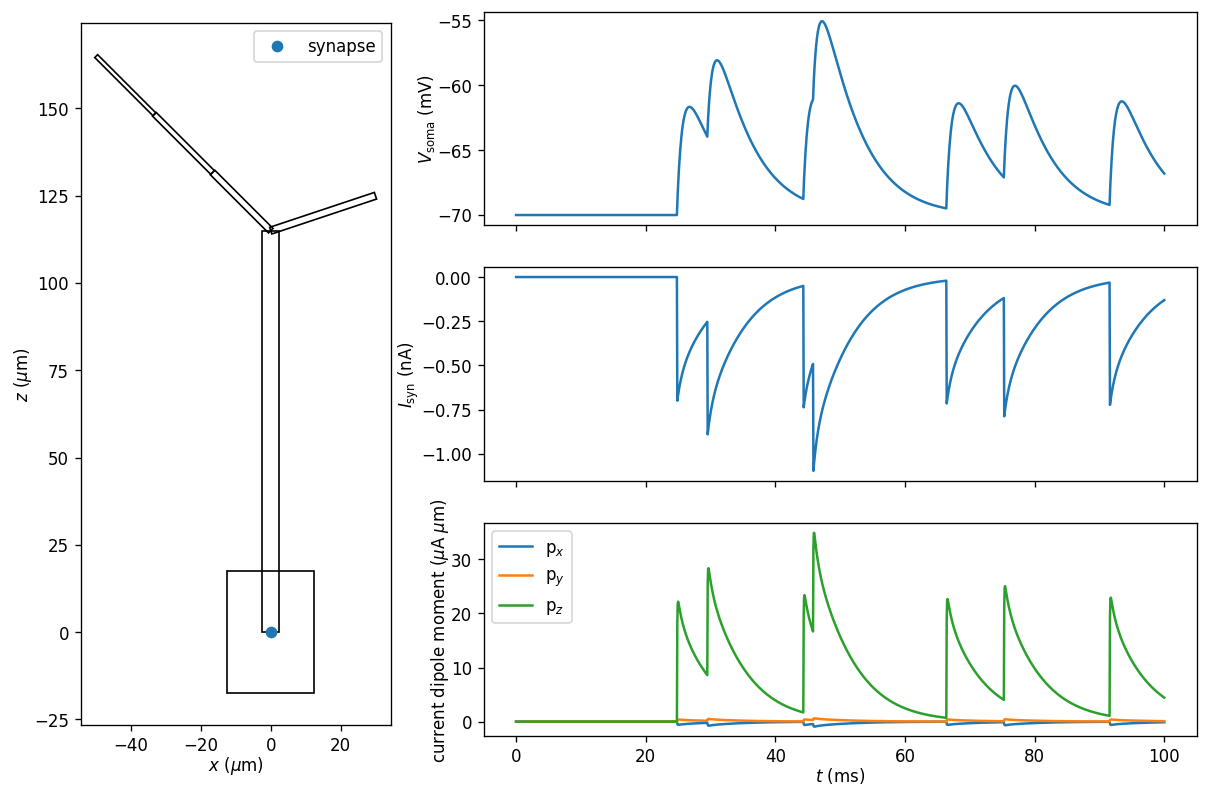

In [3]:
# plot cell 
fig = plt.figure(figsize=(12, 8), dpi=120)
gs = GridSpec(3, 3, wspace=0.3)

# cell setup and sensor locations
ax0 = fig.add_subplot(gs[:, 0], aspect=1)
for xz in cell.get_idx_polygons(projection=('x', 'z')):
    ax0.add_patch(plt.Polygon(np.stack(xz).T, ec='k', fc='none', label='__nolabel__'))
ax0.plot(cell.xmid[syn.idx], cell.zmid[syn.idx], 'o', label='synapse')

ax0.legend()
ax0.set_xlabel('$x$ ($\mu$m)', labelpad=0)
ax0.set_ylabel('$z$ ($\mu$m)', labelpad=0)

# somatic voltage
ax1 = fig.add_subplot(gs[0, 1:])
ax1.plot(cell.tvec, cell.somav)
ax1.set_ylabel(r'$V_\mathrm{soma}$ (mV)', labelpad=0)
ax1.set_xticklabels([])

# synapse current
ax2 = fig.add_subplot(gs[1, 1:])
ax2.plot(cell.tvec, syn.i)
ax2.set_ylabel(r'$I_\mathrm{syn}$ (nA)', labelpad=0)
ax2.set_xticklabels([])

# EEG
ax3 = fig.add_subplot(gs[2, 1:])
[ax3.plot(cell.tvec, p[idx], label=["p$_x$", "p$_y$", "p$_z$"][idx]) for idx in range(p.shape[0])]
ax3.set_ylabel(r'current dipole moment ($\mu$A $\mu$m)', labelpad=0)
ax3.legend()
ax3.set_xlabel('$t$ (ms)', labelpad=0)

We now initiate the New York Head model

In [4]:
nyhead = NYHeadModel()

dipole_location = 'motorsensory_cortex'  # predefined location from NYHead class
M = nyhead.get_transformation_matrix(dipole_location)

# We rotate current dipole moment to be oriented along the normal vector of cortex
p = nyhead.rotate_dipole_moment(p)
eeg = M @ p # [pV]

Closest electrode to dipole: 20.02 mm


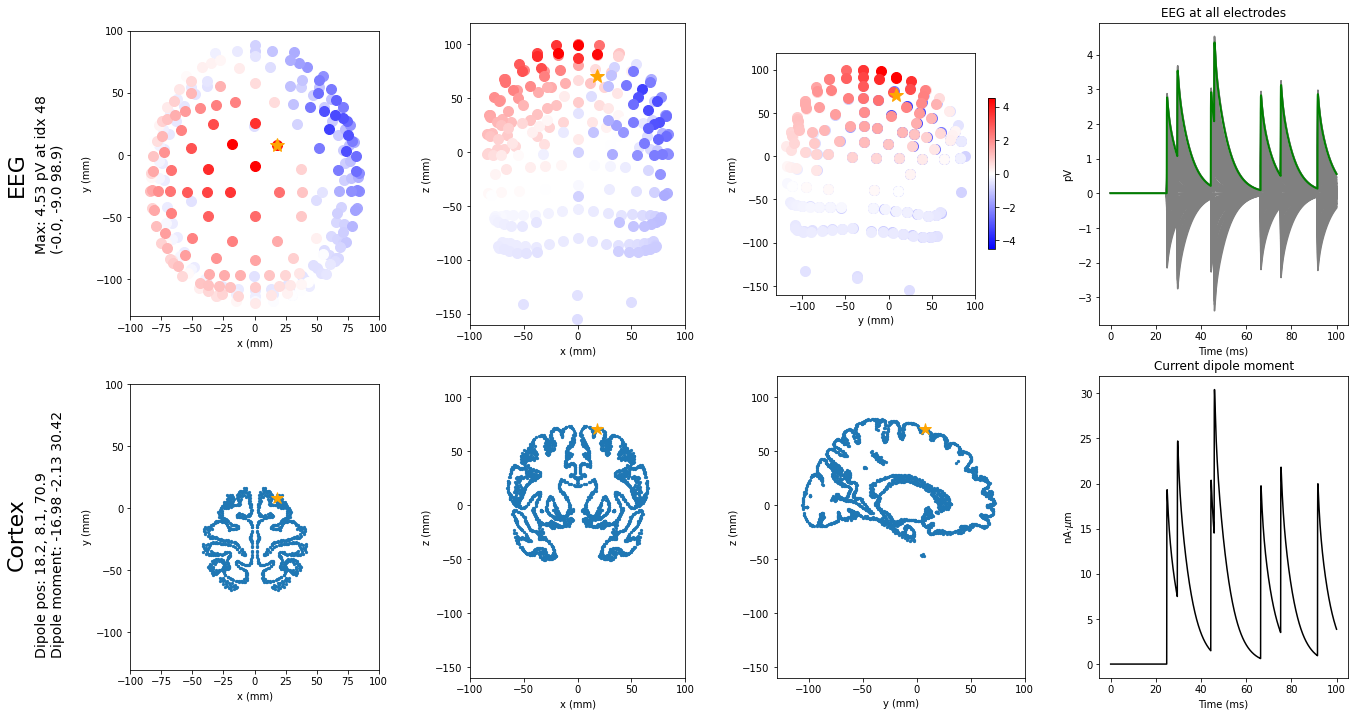

In [5]:
x_lim = [-100, 100]
y_lim = [-130, 100]
z_lim = [-160, 120]

t = cell.tvec

plt.close("all")
fig = plt.figure(figsize=[19, 10])
fig.subplots_adjust(top=0.96, bottom=0.05, hspace=0.17, wspace=0.3, left=0.1, right=0.99)
ax1 = fig.add_subplot(245, aspect=1, xlabel="x (mm)", ylabel='y (mm)', xlim=x_lim, ylim=y_lim)
ax2 = fig.add_subplot(246, aspect=1, xlabel="x (mm)", ylabel='z (mm)', xlim=x_lim, ylim=z_lim)
ax3 = fig.add_subplot(247, aspect=1, xlabel="y (mm)", ylabel='z (mm)', xlim=y_lim, ylim=z_lim)
ax_eeg = fig.add_subplot(244, xlabel="Time (ms)", ylabel='pV', title='EEG at all electrodes')

ax_cdm = fig.add_subplot(248, xlabel="Time (ms)", ylabel='nA$\cdot \mu$m', title='Current dipole moment')
dist, closest_elec_idx = nyhead.find_closest_electrode()
print("Closest electrode to dipole: {:1.2f} mm".format(dist))

max_elec_idx = np.argmax(np.std(eeg, axis=1))
time_idx = np.argmax(np.abs(eeg[max_elec_idx]))
max_eeg = np.max(np.abs(eeg[:, time_idx]))
max_eeg_idx = np.argmax(np.abs(eeg[:, time_idx]))

max_eeg_pos = nyhead.elecs[:3, max_eeg_idx]
fig.text(0.01, 0.25, "Cortex", va='center', rotation=90, fontsize=22)
fig.text(0.03, 0.25, "Dipole pos: {:1.1f}, {:1.1f}, {:1.1f}\nDipole moment: {:1.2f} {:1.2f} {:1.2f}".format(
    nyhead.dipole_pos[0], nyhead.dipole_pos[1], nyhead.dipole_pos[2],
    p[0, time_idx], p[1, time_idx], p[2, time_idx]
), va='center', rotation=90, fontsize=14)

fig.text(0.01, 0.75, "EEG", va='center', rotation=90, fontsize=22)
fig.text(0.03, 0.75, "Max: {:1.2f} pV at idx {}\n({:1.1f}, {:1.1f} {:1.1f})".format(
         max_eeg, max_eeg_idx, max_eeg_pos[0], max_eeg_pos[1], max_eeg_pos[2]), va='center',
         rotation=90, fontsize=14)

ax7 = fig.add_subplot(241, aspect=1, xlabel="x (mm)", ylabel='y (mm)',
                      xlim=x_lim, ylim=y_lim)
ax8 = fig.add_subplot(242, aspect=1, xlabel="x (mm)", ylabel='z (mm)',
                      xlim=x_lim, ylim=z_lim)
ax9 = fig.add_subplot(243, aspect=1, xlabel="y (mm)", ylabel='z (mm)',
                      xlim=y_lim, ylim=z_lim)

ax_cdm.plot(t, p[2, :], 'k')
[ax_eeg.plot(t, eeg[idx, :], c='gray') for idx in range(eeg.shape[0])]
ax_eeg.plot(t, eeg[closest_elec_idx, :], c='green', lw=2)
# print(nyhead.eeg[50, :])

vmax = np.max(np.abs(eeg[:, time_idx]))
v_range = vmax
cmap = lambda v: plt.cm.bwr((v + vmax) / (2*vmax))
# cmap = np.vectorize(plt.cm.viridis())

threshold = 2

xz_plane_idxs = np.where(np.abs(nyhead.cortex[1, :] - nyhead.dipole_pos[1]) < threshold)[0]
xy_plane_idxs = np.where(np.abs(nyhead.cortex[2, :] - nyhead.dipole_pos[2]) < threshold)[0]
yz_plane_idxs = np.where(np.abs(nyhead.cortex[0, :] - nyhead.dipole_pos[0]) < threshold)[0]

ax1.scatter(nyhead.cortex[0, xy_plane_idxs], nyhead.cortex[1, xy_plane_idxs], s=5)
ax2.scatter(nyhead.cortex[0, xz_plane_idxs], nyhead.cortex[2, xz_plane_idxs], s=5)
ax3.scatter(nyhead.cortex[1, yz_plane_idxs], nyhead.cortex[2, yz_plane_idxs], s=5)

for idx in range(eeg.shape[0]):
    c = cmap(eeg[idx, time_idx])
    ax7.plot(nyhead.elecs[0, idx], nyhead.elecs[1, idx], 'o', ms=10, c=c, zorder=nyhead.elecs[2, idx])
    ax8.plot(nyhead.elecs[0, idx], nyhead.elecs[2, idx], 'o', ms=10, c=c, zorder=nyhead.elecs[1, idx])
    ax9.plot(nyhead.elecs[1, idx], nyhead.elecs[2, idx], 'o', ms=10, c=c, zorder=-nyhead.elecs[0, idx])

img = ax3.imshow([[], []], origin="lower", vmin=-vmax,
                 vmax=vmax, cmap=plt.cm.bwr)
plt.colorbar(img, ax=ax9, shrink=0.5)

ax1.plot(nyhead.dipole_pos[0], nyhead.dipole_pos[1], '*', ms=12, color='orange', zorder=1000)
ax2.plot(nyhead.dipole_pos[0], nyhead.dipole_pos[2], '*', ms=12, color='orange', zorder=1000)
ax3.plot(nyhead.dipole_pos[1], nyhead.dipole_pos[2], '*', ms=12, color='orange', zorder=1000)

ax7.plot(nyhead.dipole_pos[0], nyhead.dipole_pos[1], '*', ms=15, color='orange', zorder=1000)
ax8.plot(nyhead.dipole_pos[0], nyhead.dipole_pos[2], '*', ms=15, color='orange', zorder=1000)
ax9.plot(nyhead.dipole_pos[1], nyhead.dipole_pos[2], '*', ms=15, color='orange', zorder=1000)

